# Logistic regression model used to predict who survived the Titanic sinking

The dataset in this example, as I understand it, is broadly available (e.g., on kaggle), but I downloaded it from the git repository of the 2nd Edition IPython Interactive Computing and Visualization Cookbook.

---

- Import libraries

In [278]:
import pandas as pd
import numpy as np
import scipy as stats
from dotenv import load_dotenv

from sklearn import model_selection as ms
from sklearn import linear_model as lm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="whitegrid")

%matplotlib inline

*Load .env file, which has paths to data sources that I prefer to keep secret*

In [279]:
load_dotenv()

True

In [280]:
#globally setting font sizes
params = {'axes.labelsize' : 16,
          'axes.titlesize' : 16, 
          'xtick.labelsize' : 16, 
          'ytick.labelsize' : 16, 
          'legend.fontsize': 16}
plt.rcParams.update(params)

---

### Table of Contents

1. [Objective/thesis of study](#obj)
1. [Import and explore the dataset](#explore)
1. [Split/normalize the data](#split_norm)
1. [Train the model](#train-model)
1. [Predict and evaluate](#predict-model)

---

---

<a id='obj'></a>
#### Objective of the study

- Predict who will survive the Titanic based on sex, age, and passenger class

- We’re using a logistic regression model to predict which passengers will survive based on certain classifications.

---

<a id='explore'></a>
#### Get and explore data; analysis and visualization

*curl download csv files from github repo with variables defined in .env, then move the files to local dicretory data_for_examples*

In [283]:
!curl $TITANIC_TRAIN -o titanic_train.csv
!curl $TITANIC_TEST -o titanic_test.csv
!mv *.csv data_for_examples/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 61194  100 61194    0     0   247k      0 --:--:-- --:--:-- --:--:--  247k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28629  100 28629    0     0   144k      0 --:--:-- --:--:-- --:--:--  144k


---

In [284]:
titanic_train = pd.read_csv('data_for_examples/titanic_train.csv')
titanic_test = pd.read_csv('data_for_examples/titanic_test.csv')

In [285]:
display(titanic_train.shape)
display(titanic_test.shape)

(891, 12)

(418, 11)

In [286]:
display(titanic_train.head())
display(titanic_test.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


---

- Assign boolean female column and keep only a few fields for this example

In [144]:
#assign female column as True/False
titanic_train = titanic_train.assign(Female=titanic_train['Sex'] == 'female')

#keep certain cols 
train_data = titanic_train[['Female', 'Age', 'Pclass', 'Survived']]

print('Total number of rows with NaN')
train_data.isna().sum()

Total number of rows with NaN


Female        0
Age         177
Pclass        0
Survived      0
dtype: int64

In [145]:
train_data = train_data.dropna()

In [146]:
display(train_data.shape)
train_data.head()

(714, 4)

,Female,Age,Pclass,Survived
0,False,22.0,3,0
1,True,38.0,1,1
2,True,26.0,3,1
3,True,35.0,1,1
4,False,35.0,3,0


- Convert df to int64

In [147]:
train_data = train_data.astype(np.int64)

In [148]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Female    714 non-null    int64
 1   Age       714 non-null    int64
 2   Pclass    714 non-null    int64
 3   Survived  714 non-null    int64
dtypes: int64(4)
memory usage: 27.9 KB


---

- Look at survival of males versus females as a function of their age, but first make some adjustments

In [149]:
tmp_df = train_data[::]
tmp_df['Survived'] = tmp_df['Survived'].apply(lambda x: 'Survived' if x==0 else 'Died')

sex_dfs = {
    'female survial': tmp_df[tmp_df['Female'] == 0],
    'male survial': tmp_df[tmp_df['Female'] == 1]
}

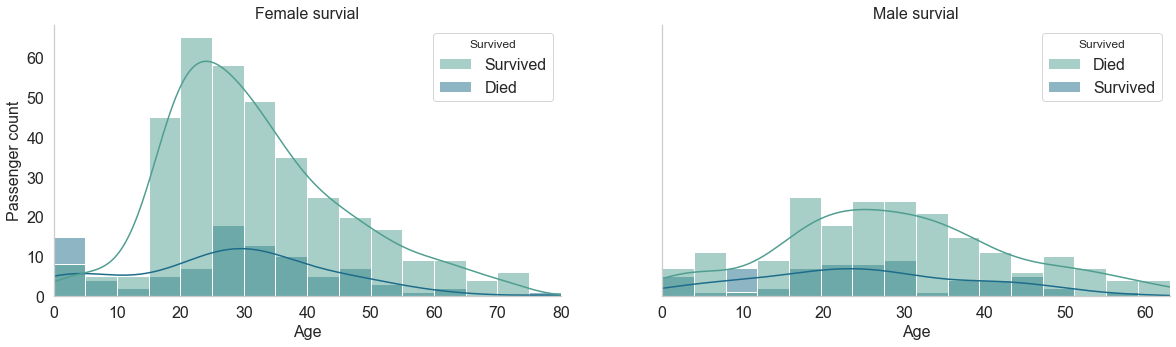

In [150]:
fig, axes = plt.subplots(1,2, figsize=(20,5), sharey=True)
sns.despine(fig)

bins = np.max(train_data['Age']) // 5
for ax, sex_df in zip(axes, sex_dfs):
    sns.histplot(
        ax=ax,
        data=sex_dfs[sex_df], 
        x='Age', 
        hue='Survived', 
        bins=bins,
        palette="crest",
        kde=True,
        )
    ax.grid()
    ax.set_ylabel('Passenger count')
    ax.set_title(sex_df.capitalize())
    ax.autoscale(axis='x', tight=True)
#     ax.legend()

---

<a id='split_norm'></a>
#### Split for testing and training

##### Convert to a np.array to make compatible with scikit-learn

1. Columns inserted into model will be used to make predictions; these **must be 2darray.**
1. Vector that will be predicted by the features **must be 1darray.**

In [277]:
train_matrix = train_data.to_numpy()
train_matrix[:10,:]

array([[ 0, 22,  3,  0],
       [ 1, 38,  1,  1],
       [ 1, 26,  3,  1],
       [ 1, 35,  1,  1],
       [ 0, 35,  3,  0],
       [ 0, 54,  1,  0],
       [ 0,  2,  3,  0],
       [ 1, 27,  3,  1],
       [ 1, 14,  2,  1],
       [ 1,  4,  3,  1]])

In [152]:
Xs = train_matrix[:, :-1]
y = train_matrix[:, -1]

In [153]:
x_train, x_test, y_train, y_test = ms.train_test_split(
    Xs, y, test_size=0.33, random_state=0
)

---

<a id='train-model'></a>
#### Train model

In [154]:
#instantiate the classifier
logreg = lm.LogisticRegression()

In [155]:
logreg.fit(x_train, y_train)

LogisticRegression()

In [156]:
ms.cross_val_score(logreg, Xs, y, cv=3)

array([0.77310924, 0.80252101, 0.78151261])

- The LogisticRegression() class accepts a C hyperparameter as an argument, which quantifies the regularization strength. Using a grid search with the generic GridSearchCV class; takes an estimator as input and a dictionary of parameter values.

<AxesSubplot:>

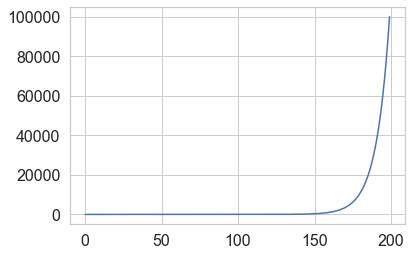

In [256]:
pd.Series(np.logspace(-5, 5, 200)).plot()

In [242]:
grid = ms.GridSearchCV(
    logreg, {'C': np.logspace(-5, 5, 200)}, n_jobs=4
)

In [243]:
grid.fit(x_train, y_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=4,
             param_grid={'C': array([1.00000000e-05, 1.12266777e-05, 1.26038293e-05, 1.41499130e-05,
       1.58856513e-05, 1.78343088e-05, 2.00220037e-05, 2.24780583e-05,
       2.52353917e-05, 2.83309610e-05, 3.18062569e-05, 3.57078596e-05,
       4.00880633e-05, 4.50055768e-05, 5.05263107e-05, 5.67242607e-05,
       6.36824994e-05, 7.14942899e-05, 8.02...
       6.98587975e+03, 7.84282206e+03, 8.80488358e+03, 9.88495905e+03,
       1.10975250e+04, 1.24588336e+04, 1.39871310e+04, 1.57029012e+04,
       1.76291412e+04, 1.97916687e+04, 2.22194686e+04, 2.49450814e+04,
       2.80050389e+04, 3.14403547e+04, 3.52970730e+04, 3.96268864e+04,
       4.44878283e+04, 4.99450512e+04, 5.60716994e+04, 6.29498899e+04,
       7.06718127e+04, 7.93409667e+04, 8.90735464e+04, 1.00000000e+05])})

In [244]:
display(grid.best_params_)
display(grid.best_estimator_)

{'C': 0.05872786613189483}

LogisticRegression(C=0.05872786613189483)

- Perfomance of the best estimator

In [246]:
ms.cross_val_score(grid.best_estimator_, Xs, y)

array([0.74125874, 0.82517483, 0.81118881, 0.78321678, 0.83802817])

---

<a id='predict-model'></a>
#### Predict model

In [247]:
predicted = logreg.predict(x_test)

In [248]:
#using GridSearchCV() class
cv_predicted = grid.predict(x_test)

In [249]:
display(predicted)
display(cv_predicted)
y_test

array([1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

array([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])

In [254]:
print("% TRUE using the simple way...")
display(np.divide((predicted == y_test).sum(), len(predicted)))

print("\n% TRUE using cross-validation...")
np.divide((cv_predicted == y_test).sum(), len(cv_predicted))

% TRUE using the simple way...


0.8389830508474576


% TRUE using cross-validation...


0.8305084745762712

---

Text(0.5, 1.0, 'Actual versus projected survival outcomes on the test set')

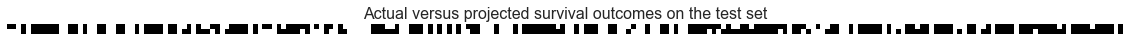

In [252]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))

ax.imshow(np.vstack((y_test, predicted)), interpolation='none', cmap='bone')
ax.set_axis_off()
ax.set_title("Actual versus projected survival outcomes on the test set")

---